<a href="https://colab.research.google.com/github/mohanrajmit/AGE_ESTIMATION/blob/master/Simplified_SingleBoundingBox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object localization - Bounding Box

---



## The Oxford-IIIT Pet Dataset
Omkar M Parkhi, Andrea Vedaldi, Andrew Zisserman and C. V. Jawahar have created a 37 category pet dataset with roughly 200 images for each class. The images have a large variations in scale, pose and lighting. All images have an associated ground truth annotation of breed, head ROI, and pixel level trimap segmentation.

Link to dataset: http://www.robots.ox.ac.uk/~vgg/data/pets/

Firstly, let's select TensorFlow version 2.x in colab

In [1]:
# %tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.11.0'

In [2]:
# Initialize the random number generator
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
!wget https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz

--2023-02-19 09:12:04--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-stream]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  14.6MB/s    in 55s     

2023-02-19 09:13:00 (13.9 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]



In [4]:
!tar -xvzf /content/images.tar.gz

Streaming output truncated to the last 5000 lines.
images/american_bulldog_194.jpg
images/Birman_175.jpg
images/american_bulldog_178.jpg
images/staffordshire_bull_terrier_93.jpg
images/Egyptian_Mau_58.jpg
images/havanese_44.jpg
images/english_cocker_spaniel_97.jpg
images/Ragdoll_111.jpg
images/american_pit_bull_terrier_159.jpg
images/english_setter_134.jpg
images/english_setter_87.jpg
images/wheaten_terrier_198.jpg
images/pug_180.jpg
images/boxer_172.jpg
images/Sphynx_197.jpg
images/german_shorthaired_2.jpg
images/British_Shorthair_9.jpg
images/pug_89.jpg
images/japanese_chin_39.jpg
images/Ragdoll_20.jpg
images/american_bulldog_111.jpg
images/yorkshire_terrier_112.jpg
images/Persian_88.jpg
images/pug_9.jpg
images/Birman_40.jpg
images/British_Shorthair_272.jpg
images/havanese_7.jpg
images/pomeranian_154.jpg
images/beagle_49.jpg
images/British_Shorthair_94.jpg
images/Persian_90.jpg
images/staffordshire_bull_terrier_30.jpg
images/samoyed_113.jpg
images/english_cocker_spaniel_46.jpg
images

### Load the dataset

In [5]:
project_path = '/content/images'

Let's load the dataset now

In [6]:
DATASET_FOLDER = "/content/images"
TRAIN_CSV = "/content/train.csv"
VALIDATION_CSV = "/content/validation.csv"

In [7]:
DATASET_FOLDER

'/content/images'

In [8]:
import pandas as pd
df_train=pd.read_csv(TRAIN_CSV)
df_train.head()

,name,h,w,x0,y0,x1,y1,class,class_label
0,Abyssinian_1.jpg,400,600,173,72,265,158,abyssinian,0
1,Abyssinian_10.jpg,500,375,72,105,288,291,abyssinian,0
2,Abyssinian_100.jpg,500,394,151,71,335,267,abyssinian,0
3,Abyssinian_101.jpg,313,450,54,36,319,235,abyssinian,0
4,Abyssinian_102.jpg,465,500,23,27,325,320,abyssinian,0


In [9]:
df_train['path']="/content/images/"+df_train['name']

In [10]:
df_train['bb_width']=df_train['x1']-df_train['x0']
df_train['bb_height']=df_train['y1']-df_train['y0']

In [11]:
df_train.head()

,name,h,w,x0,y0,x1,y1,class,class_label,path,bb_width,bb_height
0,Abyssinian_1.jpg,400,600,173,72,265,158,abyssinian,0,/content/images/Abyssinian_1.jpg,92,86
1,Abyssinian_10.jpg,500,375,72,105,288,291,abyssinian,0,/content/images/Abyssinian_10.jpg,216,186
2,Abyssinian_100.jpg,500,394,151,71,335,267,abyssinian,0,/content/images/Abyssinian_100.jpg,184,196
3,Abyssinian_101.jpg,313,450,54,36,319,235,abyssinian,0,/content/images/Abyssinian_101.jpg,265,199
4,Abyssinian_102.jpg,465,500,23,27,325,320,abyssinian,0,/content/images/Abyssinian_102.jpg,302,293


In [12]:
df_train=df_train[['path','h','w','x0','y0','bb_width','bb_height']]

In [ ]:
df_train.head()

,path,h,w,x0,y0,bb_width,bb_height
0,/content/images/Abyssinian_1.jpg,400,600,173,72,92,86
1,/content/images/Abyssinian_10.jpg,500,375,72,105,216,186
2,/content/images/Abyssinian_100.jpg,500,394,151,71,184,196
3,/content/images/Abyssinian_101.jpg,313,450,54,36,265,199
4,/content/images/Abyssinian_102.jpg,465,500,23,27,302,293


### Get training data

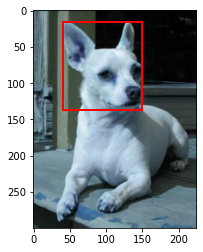

In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import numpy as np
image_index=np.random.randint(0,df_train.shape[0])
#image_index=3
# Create figure and axes
fig,ax = plt.subplots(1)
filename=df_train['path'][image_index]
x0=df_train['x0'].iloc[image_index]
y0=df_train['y0'].iloc[image_index]
bb_width=df_train['bb_width'].iloc[image_index]
bb_height=df_train['bb_height'].iloc[image_index]
# Display the image
img=cv2.imread(filename)
ax.imshow(img)


# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), bb_width, bb_height, linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

In [18]:
IMAGE_SIZE = 128 # Image sizes can vary (128, 160, 192, 224). MobileNetV2 can also take 96
X_train=[0]*df_train.shape[0]
from PIL import Image
from tensorflow.keras.applications.mobilenet import preprocess_input

for i, f in enumerate(df_train['path']):
  img = Image.open(f) # Read image
  img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
  img = img.convert('RGB')

  X_train[i] = preprocess_input(np.array(img, dtype=np.float32)) # Convert to float32 array
  img.close()

In [19]:
X_train = np.array(X_train)
X_train.shape

(3006, 128, 128, 3)

In [20]:
y_train = np.zeros((df_train.shape[0], 4))
y_train[:,0]=df_train['x0']*IMAGE_SIZE / df_train['w']
y_train[:,1]=df_train['y0']*IMAGE_SIZE / df_train['h']
y_train[:,2]=df_train['bb_width']*IMAGE_SIZE / df_train['w']
y_train[:,3]=df_train['bb_height']*IMAGE_SIZE / df_train['h']

In [21]:
y_train.shape

(3006, 4)

In [22]:
y_train[0]

array([36.90666667, 23.04      , 19.62666667, 27.52      ])

 173*128/600	72	92	86

 Validation dataset

In [23]:
df_val=pd.read_csv("/content/validation.csv")

In [24]:
df_val['path']="/content/images/"+df_val['name']

In [25]:
df_val['bb_width']=df_val['x1']-df_val['x0']
df_val['bb_height']=df_val['y1']-df_val['y0']

In [26]:
IMAGE_SIZE = 128 # Image sizes can vary (128, 160, 192, 224). MobileNetV2 can also take 96
X_val=[0]*df_val.shape[0]
from PIL import Image
from tensorflow.keras.applications.mobilenet import preprocess_input

for i, f in enumerate(df_val['path']):
  img = Image.open(f) # Read image
  img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
  img = img.convert('RGB')

  X_val[i] = preprocess_input(np.array(img, dtype=np.float32)) # Convert to float32 array
  img.close()

In [27]:
X_val = np.array(X_val)

In [28]:
X_val.shape

(680, 128, 128, 3)

In [29]:
y_val = np.zeros((df_val.shape[0], 4))
y_val[:,0]=df_val['x0']*IMAGE_SIZE / df_val['w']
y_val[:,1]=df_val['y0']*IMAGE_SIZE / df_val['h']
y_val[:,2]=df_val['bb_width']*IMAGE_SIZE / df_val['w']
y_val[:,3]=df_val['bb_height']*IMAGE_SIZE / df_val['h']

In [30]:
y_val.shape

(680, 4)

### Create the model

In [31]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Reshape

ALPHA = 1.0 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet
    # Do not include classification (top) layer

    # to freeze layers, except the new top layer, of course, which will be added below
    for layer in model.layers:
        layer.trainable = trainable

    # Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
    x0 = model.layers[-1].output
    x1 = Conv2D(4, kernel_size=4, name="coords")(x0)
    # In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
    x2 = Reshape((4,))(x1) # These are the 4 predicted coordinates of one BBox
    return Model(inputs=model.input, outputs=x2)

### Define evaluation metric

In [32]:
def IOU(y_true, y_pred):
    intersections = 0
    unions = 0
    # set the types so we are sure what type we are using

    gt = y_true
    pred = y_pred
    # Compute interection of predicted (pred) and ground truth (gt) bounding boxes
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height

    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

    # Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
      if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
        intersections += intersection[j]
        unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + tensorflow.keras.backend.epsilon()), 4)
    # This must match the type used in py_func
    iou = iou.astype(np.float32)
    return iou

In [33]:
## Wraps a python function into a TensorFlow op that executes it eagerly.
def IoU(y_true, y_pred):
    iou = tensorflow.py_function(IOU, [y_true, y_pred], Tout=tensorflow.float32)
    return iou

### Initialize the model and print summary

In [34]:
model = create_model(False) # Arg is False, if you want to freeze lower layers for fast training (but low accuracy)
model.summary() # Print summary

17225924/17225924 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32)       128    

### Compile the model
- loss: "mean_squared_error"
- metrics: IoU
- optimizer: "adam"

In [35]:
# Compile the model
model.compile(loss="mean_squared_error", optimizer="adam", metrics=[IoU]) # Regression loss is MSE

### Training the model

Fit the model to the dataset
- Use early stopping
- fit the model
    - give train data - training features and labels
    - batch size: 32
    - epochs: 10
    - give validation data - testing features and labels

In [36]:
# Use earlystopping
callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_IoU', patience=5, min_delta=0.01)

# Fit the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, callbacks=[callback])

Epoch 1/10
94/94 [==============================] - 24s 141ms/step - loss: 281.6189 - IoU: 0.4957 - val_loss: 112.5903 - val_IoU: 0.6206
Epoch 2/10
94/94 [==============================] - 12s 129ms/step - loss: 81.1152 - IoU: 0.6638 - val_loss: 95.3300 - val_IoU: 0.6449
Epoch 3/10
94/94 [==============================] - 12s 124ms/step - loss: 54.2676 - IoU: 0.7108 - val_loss: 87.9333 - val_IoU: 0.6575
Epoch 4/10
94/94 [==============================] - 12s 124ms/step - loss: 39.3980 - IoU: 0.7484 - val_loss: 86.6683 - val_IoU: 0.6578
Epoch 5/10
94/94 [==============================] - 12s 129ms/step - loss: 29.4458 - IoU: 0.7792 - val_loss: 88.1608 - val_IoU: 0.6579
Epoch 6/10
94/94 [==============================] - 12s 129ms/step - loss: 23.2213 - IoU: 0.8008 - val_loss: 86.8099 - val_IoU: 0.6573


### Final loss and accuracy

In [ ]:
model.evaluate(X_val, y_val)

22/22 [==============================] - 2s 105ms/step - loss: 88.0234 - IoU: 0.6578


[88.02339935302734, 0.6578091979026794]

### Test the model on an image from test data

In [ ]:
X_val[0].shape

(128, 128, 3)

In [ ]:
region = model.predict(x=np.array([X_val[0]]))[0] # Predict the BBox

1/1 [==============================] - 1s 724ms/step


In [ ]:
region

array([10.488655, 16.511393, 67.39939 , 54.92993 ], dtype=float32)

In [ ]:
df_val.head()

,name,h,w,x0,y0,x1,y1,class,class_label,path,bb_width,bb_height
0,Abyssinian_118.jpg,500,333,1,34,257,303,abyssinian,0,/content/images/Abyssinian_118.jpg,256,269
1,Abyssinian_124.jpg,500,333,88,94,207,195,abyssinian,0,/content/images/Abyssinian_124.jpg,119,101
2,Abyssinian_131.jpg,320,311,17,25,206,180,abyssinian,0,/content/images/Abyssinian_131.jpg,189,155
3,Abyssinian_14.jpg,500,335,164,71,252,163,abyssinian,0,/content/images/Abyssinian_14.jpg,88,92
4,Abyssinian_15.jpg,422,477,16,16,431,357,abyssinian,0,/content/images/Abyssinian_15.jpg,415,341


In [ ]:
image_no=30
filename=df_val['path'][image_no]
unscaled = cv2.imread(filename)
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))
print ("Size of original input: ", unscaled.shape)
print("-------------------------------")
print("Size of scaled input: ", feat_scaled.shape)

Size of original input:  (225, 300, 3)
-------------------------------
Size of scaled input:  (128, 128, 3)


In [ ]:
region = model.predict(x=np.array([feat_scaled]))[0] # Predict the BBox

1/1 [==============================] - 0s 23ms/step


In [ ]:
region

array([ 2.617257, 14.751272, 72.883736, 62.731266], dtype=float32)

Fetching coordinates details

In [ ]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

bb_width = int((region[2]) * image_width / IMAGE_SIZE)
bb_height = int(region[3]) * image_height / IMAGE_SIZE

Now, let's plot the image and the bounding box on top of it

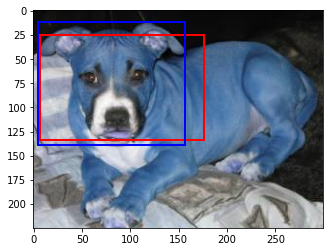

In [ ]:
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), bb_width, bb_height, linewidth=2, edgecolor='r', facecolor='none')
rect1 = patches.Rectangle((df_val['x0'].iloc[image_no], df_val['y0'].iloc[image_no]), df_val['bb_width'].iloc[image_no], df_val['bb_height'].iloc[image_no], linewidth=2, edgecolor='b', facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)
ax.add_patch(rect1)
plt.show()